In [1]:
import sys

sys.path.append("../")

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

In [3]:
import neural.binary_modules as bm
import neural.utilities as utils

#### Training preliminaries

In [4]:
def plot_values(values, subplot=None, **kwargs):
    # clear_output(True)
    if subplot:
        plt.subplot(*subplot)
  
    plt.plot(np.arange(len(values)) + 1, values, **kwargs)
    plt.xlabel("n_epoch")
    plt.legend()
    # plt.show()


def matrix_accuracy(A: np.array, B: np.array):
    assert A.shape == B.shape
    return np.sum(np.abs(A - B)) / A.size

In [5]:
def train_over_matrix(matrix, model, criterion, optimizer,
                      batch_size=16, n_epochs=10):
    
    train_loader = DataLoader(utils.matrix_to_ids(matrix), batch_size=batch_size)
    losses_per_epoch = list()
    fact_acc = list()
    intermediate_user_factors = list()
    intermediate_item_factors = list()

    for epoch in tqdm(range(n_epochs)):
        losses_per_batch = list()

        for i, batch in enumerate(train_loader):
            model_output = model(batch)
            target = batch[:, 2].float()

            optimizer.zero_grad()
            train_loss = criterion(model_output, target)
            train_loss.backward()
            optimizer.step()
            losses_per_batch.append(train_loss.detach().numpy())
            
        losses_per_epoch.append(np.array(losses_per_batch).mean())

        clear_output(True)
        plt.figure(figsize=(12, 3))
        plot_values(losses_per_epoch, subplot=(1, 2, 1), label=str(criterion), color="green")
        plot_values(fact_acc, subplot=(1, 2, 2), label="Factorization accuracy", color="maroon")
        plt.show()
        
        if epoch % 10 == 0:
            # Calculating factorization error
            temp_user_factor = (np.sign(model.user_embedding_b.weight.detach().clone().numpy()) + 1) / 2
            temp_item_factor = (np.sign(model.item_embedding_b.weight.detach().clone().numpy()) + 1) / 2
            approx_matrix = utils.bin_matmul_1(temp_user_factor, temp_item_factor.T)
            fact_acc.append(matrix_accuracy(approx_matrix, matrix.numpy()))
            
        if epoch % 20 == 0:
            intermediate_user_factors.append(temp_user_factor)
            intermediate_item_factors.append(temp_item_factor)
            

    user_bin_emb = (bm.binarized(model.user_embedding_b.weight) + 1) / 2
    item_bin_emb = (bm.binarized(model.item_embedding_b.weight) + 1) / 2

    output = {
        "user_bin_emb": user_bin_emb.detach().numpy(),
        "item_bin_emb": item_bin_emb.detach().numpy(),
        "losses_per_epoch": losses_per_epoch,
        "fact_acc": fact_acc,
        "iuf": intermediate_user_factors,
        "iif": intermediate_item_factors
    }

    return output

#### Training BinaryNCF over a matrix

In [6]:
n_users = 32
n_items = 32
emb_size = 8

model = bm.NeuralBMF(n_users, n_items, emb_size)
matrix = utils.get_binary_tensor((n_users, n_items))

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

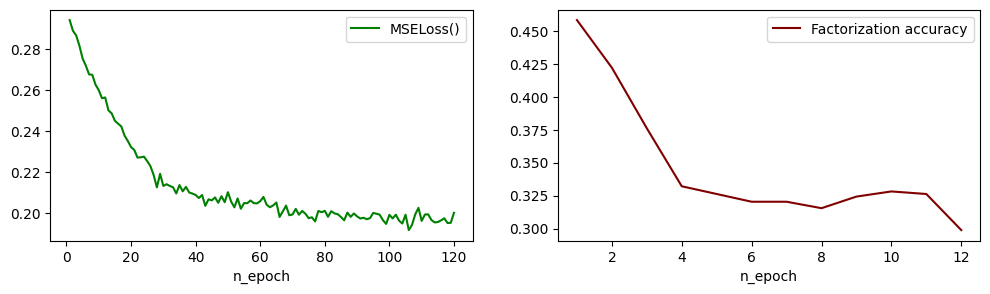

In [7]:
output = train_over_matrix(
    matrix=matrix,
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    batch_size=16, n_epochs=120
)

In [74]:
A = utils.bin_matmul_1(user_bin_emb, item_bin_emb.T)
print(type(A), A.shape)
m = matrix.numpy()
print(type(m), m.shape)

<class 'numpy.ndarray'> (32, 32)
<class 'numpy.ndarray'> (32, 32)


In [ ]:
print([p for p in model.named_parameters()])

#### Results explorations

In [8]:
user_factors, item_factors = output["iuf"], output["iif"]

for fact in user_factors:
    print(f"(UserFactor): {int(np.sum(fact))} ones of {fact.size} total cells")
print()
for fact in item_factors:
    print(f"(ItemFactor): {int(np.sum(fact))} ones of {fact.size} total cells")

(UserFactor): 114 ones of 256 total cells
(UserFactor): 99 ones of 256 total cells
(UserFactor): 99 ones of 256 total cells
(UserFactor): 103 ones of 256 total cells
(UserFactor): 101 ones of 256 total cells
(UserFactor): 108 ones of 256 total cells

(ItemFactor): 129 ones of 256 total cells
(ItemFactor): 106 ones of 256 total cells
(ItemFactor): 97 ones of 256 total cells
(ItemFactor): 98 ones of 256 total cells
(ItemFactor): 106 ones of 256 total cells
(ItemFactor): 99 ones of 256 total cells


In [9]:
user_bin_emb, item_bin_emb = output["user_bin_emb"], output["item_bin_emb"]

print(user_bin_emb.shape, item_bin_emb.shape)
print(matrix)
print(utils.bin_matmul_1(user_bin_emb, item_bin_emb.T))
matrix_accuracy(matrix.numpy(), utils.bin_matmul_1(user_bin_emb, item_bin_emb.T))

(32, 8) (32, 8)
tensor([[1, 1, 0,  ..., 1, 1, 0],
        [1, 0, 0,  ..., 1, 1, 1],
        [1, 1, 0,  ..., 1, 1, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 1],
        [1, 0, 0,  ..., 1, 1, 1],
        [0, 1, 0,  ..., 1, 1, 0]], dtype=torch.int8)
[[1 1 0 ... 1 1 1]
 [1 1 0 ... 1 1 1]
 [1 1 0 ... 1 1 1]
 ...
 [0 1 1 ... 1 0 1]
 [1 0 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]]


0.31640625

In [193]:
# We see that for all users all the raw latent coordinates move to the left -> negative area is zeroed

raw_uw = model.user_embedding_b.weight.detach().numpy()
np.stack((raw_uw.min(axis=1), raw_uw.max(axis=1)), axis=1)

array([[-3.9180057, -3.333113 ],
       [-4.4540567, -3.693341 ],
       [-4.111192 , -3.449139 ],
       [-4.4947724, -3.7817307],
       [-4.3568482, -3.8546305],
       [-4.42169  , -3.8390915],
       [-3.9966738, -3.6086113],
       [-4.3652925, -4.1709986],
       [-4.480802 , -3.8727   ],
       [-4.239615 , -3.6560707],
       [-3.8122718, -3.3263106],
       [-4.1978016, -3.7548048],
       [-4.3778005, -3.6785414],
       [-4.191657 , -3.7956843],
       [-4.3138127, -3.8618095],
       [-4.2553773, -3.7951038],
       [-4.482611 , -3.95746  ],
       [-4.2907352, -3.7573724],
       [-4.1900406, -3.8511977],
       [-4.3458548, -3.8292985],
       [-4.385749 , -3.6401253],
       [-4.2326884, -3.6835897],
       [-4.4998384, -3.758671 ],
       [-4.133841 , -3.6719286],
       [-4.357868 , -3.7747293],
       [-4.368151 , -3.8505373],
       [-4.427814 , -3.7843146],
       [-4.3136234, -3.6533022],
       [-4.3257623, -3.924817 ],
       [-4.28131  , -3.7365227],
       [-4